**maskAI : *Open* COVID19 Prediction App**
![Source: CDC](https://images.unsplash.com/photo-1583324113626-70df0f4deaab?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1189&q=80)

**How to run?**

1.   Login to Google, click on the following cell (code) and press Ctrl + Enter or press the *Play* button on the left side of the cell (for mobile users)
2.   Go to the bottom of the page to give input



**Login to Google, click on the following cell (code) and press Ctrl + Enter or press the *Play* button on the left side of the cell (for mobile users)**

You need to give input over last five days and press enter
Day1 = Today, Day2 = Yesterday, Day3 = Day before yesterday and so on.
------------------------------------------------------------------
Day1 (cumulative count): 
9580
Day2 (cumulative count): 
8345
Day3 (cumulative count): 
7173
Day4 (cumulative count): 
6179
Day5 (cumulative count): 
5290
Current average temperature at the place (degree celcius): 
25
Median age of population at the place (years): 
28
Total number of days need to be predicted (days): 
10
Please wait for 10 minutes to get the graph below ...
Fetching training data ...
Training starts ...
('Train Data-set: Mean Rel Error of the model in %: ', 3.751287694550455)
('Validation Data-set : Mean Rel Error of the model in %: ', 4.0597502047303715)


Text(0,0.5,'No of cases')

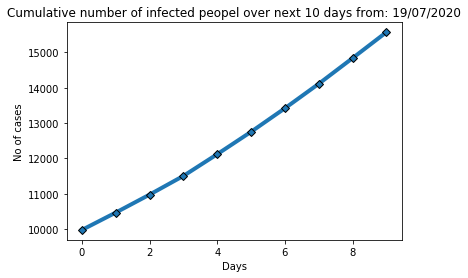

In [ ]:
# Importing Lib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
 
# Finding RMSE
def ErrorCalc(mdl, ref, tag):
    relError = np.abs(mdl - ref)/ np.abs(ref+1)
    MeanErrorV = np.mean(relError)
    print(tag + ': Mean Rel Error of the model in %: ', MeanErrorV * 100)
    return MeanErrorV
 
# Since cumulative prediction
def AdjustingErrorsOutliers(tempPred, df) :
    tempPred = np.round(tempPred)
    tempPrev = df['day5'].to_numpy() # Next cumulative prediction must be more than or equal to previous
    for i in range(len(tempPred)):
        if tempPred[i] < tempPrev[i] : # Since cumulative prediction
            tempPred[i] = tempPrev[i]
    return tempPred
 
# Proposed model
def TrainMdl (trainIpData, trainOpData) :
    testSize = 0.1 # 90:10 ratio >> for final testing
    #randomState = 42 # For train test split
 
    print('Training starts ...')
    randomState = 42
    # Final validation after mixing dataset
    X_train, X_test, y_train, y_test = train_test_split(trainIpData, trainOpData, test_size=testSize, random_state=randomState)
 
    # Extrating features
    TrainIP = X_train[['diff1', 'diff2', 'diff3', 'diff4', 'tempVal', 'ageVal']]
    TrainOP = X_train['gammaFun']
    TestIP = X_test[['diff1', 'diff2', 'diff3', 'diff4', 'tempVal', 'ageVal']]
    TestOP = X_test['gammaFun']
 
    # Adaboost Regressor defined
    treeDepth = 10 # Fixed
    mdl = DecisionTreeRegressor(max_depth=treeDepth)
        
    # Defining the search grid
    param_grid = {
          'n_estimators': [10, 50, 100, 250, 500],
          'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.001]
                      }
    regrMdl = AdaBoostRegressor(base_estimator=mdl)
    clf = RandomizedSearchCV(estimator = regrMdl, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
 
    # Fit
    clf.fit(TrainIP, TrainOP)
 
    # Evaluation of estimation function "gamma" using training dataset
    y_predictedTrain = clf.predict(TrainIP)
    y_predictedTrain = AdjustingErrorsOutliers(y_predictedTrain * X_train['day5'].to_numpy(), X_train)
    ErrorCalc(y_predictedTrain, y_train.to_numpy(), 'Train Data-set') # Mean relative error calculated
 
    # Evaluation of estimation function "gamma" using validation dataset
    y_predictedTest = clf.predict(TestIP)
    y_predictedTest = AdjustingErrorsOutliers(y_predictedTest * X_test['day5'].to_numpy(), X_test)
    ErrorCalc(y_predictedTest, y_test.to_numpy(), 'Validation Data-set ') # Mean relative error calculated
 
    # Returning the model
    return clf
 
 
# Settings
displayAll = 1
if displayAll == 1 :
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
 
# User input
print('You need to give input over last five days and press enter')
print('Day1 = Today, Day2 = Yesterday, Day3 = Day before yesterday and so on.')
print('------------------------------------------------------------------')
print('Day1 (cumulative count): ')
count5 = input()
print('Day2 (cumulative count): ')
count4 = input()
print('Day3 (cumulative count): ')
count3 = input()
print('Day4 (cumulative count): ')
count2 = input()
print('Day5 (cumulative count): ')
count1 = input()
print('Current average temperature at the place (degree celcius): ')
temperature = input()
print('Median age of population at the place (years): ')
medianAge = input()
print('Total number of days need to be predicted (days): ')
horizon = input()
print('Please wait for 10 minutes to get the graph below ...')
print('Fetching training data ...')
 
# Fetch JHU Dataset and pre-process data
worldCorona = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
worldCorona = worldCorona.fillna(0)
worldCorona = worldCorona.drop(['Province/State'], axis=1)
worldCorona['Country'] = worldCorona['Country/Region']
worldCorona = worldCorona.drop(['Country/Region', 'Lat', 'Long'], axis=1)
worldCorona = worldCorona.groupby(['Country']).sum()
worldCorona.to_csv('Hellos.csv')
worldCorona = pd.read_csv('Hellos.csv')
 
# Read total countries in the world
totalCountries = pd.read_csv('https://raw.githubusercontent.com/neilay-khasnabish/COVID-19/master/WorldCountryNames.csv')
 
# Read Countrywise temperature
countryTemp = pd.read_csv('https://raw.githubusercontent.com/neilay-khasnabish/COVID-19/master/Temp.csv')
 
# Read Countrywise age
countryAge = pd.read_csv('https://raw.githubusercontent.com/neilay-khasnabish/COVID-19/master/MedAge.csv')
 
# Merging all three
result1 = pd.merge(worldCorona, countryTemp, on='Country').reset_index(drop=True)
result = pd.merge(result1, countryAge, on='Country').reset_index(drop=True)
#print('Final size of merged data (rows equal to number of countries to be processed): ', np.shape(result))
result.to_csv('hellow.csv')
 
# Creating dataframe for training
[rf, cf] = np.shape(result)
#print('Row', rf, '| Col: ', cf)
df=[]
for i in range(rf): # It scans through the entire row
    iCol = 6 # Start index
    while iCol <= cf-4 :
        dayPredict = result.iloc[i, iCol+1]
        day5 = result.iloc[i, iCol]
        day4 = result.iloc[i, iCol-1]
        day3 = result.iloc[i, iCol-2]
        day2 = result.iloc[i, iCol-3]
        day1 = result.iloc[i, iCol-4]
        diff1 = day5 - day4
        diff2 = day4 - day3
        diff3 = day3 - day2
        diff4  = day2 - day1
        iCol = iCol + 1
        ageVal = result.iloc[i, cf - 1]
        tempVal = result.iloc[i, cf - 2]
        dividen = day5 + 1
        gammaFun = float(dayPredict) / dividen
        data = {'day1': [day1], 'day2': [day2], 'day3': [day3], 'day4': [day4], 'day5': [day5], 'tempVal': [tempVal], 'ageVal': [ageVal],
                'dayPredict': [dayPredict], 'gammaFun': [gammaFun], 'diff1': [diff1], 'diff2': [diff2], 'diff3': [diff3], 'diff4': [diff4]}
        df2 = pd.DataFrame(data)
        df.append(df2)
 
df = pd.concat(df).reset_index(drop=True)
df = df.fillna(0)
df.to_csv('TrainTest.csv')
 
df = pd.read_csv('TrainTest.csv')
trainIpData = df[['day1', 'day2', 'day3', 'day4', 'day5', 'tempVal', 'ageVal', 'gammaFun', 'diff1', 'diff2', 'diff3', 'diff4']]
trainOpData = df['dayPredict']
clf = TrainMdl(trainIpData, trainOpData)
 
## PREDICTION AS PER USER INPUT
day5 = count5
day4 = count4
day3 = count3
day2 = count2
day1 = count1
tempVal = temperature
ageVal = medianAge
dayCount = horizon 
 
# Create list
listCount = np.zeros((dayCount,))
 
# Plotting graph
for i in range(dayCount) :
  # Internal calculations
  diff1 = day5 - day4
  diff2 = day4 - day3
  diff3 = day3 - day2
  diff4 = day2 - day1
 
  # Create dataframe
  d = {'diff1': [diff1], 'diff2': [diff2], 'diff3': [diff3], 'diff4': [diff4], 'tempVal': [tempVal], 'ageVal': [ageVal], 'day5': [day5]}
  df = pd.DataFrame(data=d)
  # print(df.head())
 
  # Prediction starts
  PredictionDataF = df[['diff1', 'diff2', 'diff3', 'diff4', 'tempVal', 'ageVal']]
  finalPrediction = clf.predict(PredictionDataF)  # Predicting the gamma function
  tempPred = finalPrediction * df['day5'].to_numpy()
  if tempPred < df['day5'].to_numpy() : # Since cumulative prediction
    tempPred = df['day5'].to_numpy() # Next cumulative prediction must be more than or equal to previous
  y_predictedFinal0 = tempPred
  listCount[i] = int(y_predictedFinal0)
 
  # Next loop
  day1 = day2
  day2 = day3
  day3 = day4
  day4 = day5
  day5 = int(y_predictedFinal0)
 
# Plot graph
from datetime import date
plt.figure()
plt.plot(listCount, linewidth=4, marker='D', markeredgecolor='black')
today = date.today()
plt.title('Cumulative number of infected peopel over next ' + str(dayCount) + ' days from: ' + today.strftime("%d/%m/%Y"))
plt.xlabel('Days')
plt.ylabel('No of cases')

**This work is published in the following publications:**

1.   Data Driven Investor (Analysis of COVID-19 with Data Science) https://medium.com/datadriveninvestor/predictions-about-covid-19-with-data-science-bc45c22bda5e
2.   Analytics Vidhya (Modelling the Dynamics of the Spread of COVID-19 Using AI) https://medium.com/analytics-vidhya/modelling-the-dynamics-of-the-spread-of-covid-19-using-ai-946530e06b46




